 # Import Libraries

In [ ]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

import matplotlib.pyplot as plt
from tensorflow import keras

# Set Parameters

In [ ]:
# Parameters
BUFFER_SIZE = 10000  # Maximum number of words to consider as features
VOCAB_SIZE = 1000    # Maximum length of reviews (in words)
EMBEDDING_DIM = 64   # Dimension of the embedding space
BATCH_SIZE = 64
epochs = 10

# Load Dataset

In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# TextVectorization layer to process data before model
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

# Define and Train Model

In [ ]:
def create_and_train_model(optimizer, learning_rate):
    model = tf.keras.Sequential([
      encoder,
      # Embedding layer
      tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()), output_dim=EMBEDDING_DIM, mask_zero=True),

      # First LSTM layer
      tf.keras.layers.LSTM(64, return_sequences=True),

      # Second LSTM layer
      tf.keras.layers.LSTM(64),

      # Fully connected layer
      tf.keras.layers.Dense(64, activation='relu'),

      # Output layer
      tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Compile the model
    if optimizer == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=opt,
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    # Train the model
    history = model.fit(
        train_dataset,
        batch_size=BATCH_SIZE,
        epochs=epochs,
        verbose=1,
        validation_data=test_dataset
    )

    # Evaluate the model
    test_loss, test_acc = model.evaluate(test_dataset)
    train_loss, train_acc = model.evaluate(train_dataset)

    print(f"\nOptimizer: {optimizer}, Learning Rate: {learning_rate}")
    print(f"Training accuracy: {train_acc:.4f}")
    print(f"Test accuracy: {test_acc:.4f}")

    return {
        'optimizer': optimizer,
        'learning_rate': learning_rate,
        'train_acc': train_acc,
        'val_acc': test_acc,
        'history': history.history
    }

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:780: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


391/391 ━━━━━━━━━━━━━━━━━━━━ 38s 79ms/step - accuracy: 0.6558 - loss: 0.6014 - val_accuracy: 0.7167 - val_loss: 0.5598
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 38s 79ms/step - accuracy: 0.7840 - loss: 0.4568 - val_accuracy: 0.8222 - val_loss: 0.4024
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 30s 76ms/step - accuracy: 0.8335 - loss: 0.3852 - val_accuracy: 0.8284 - val_loss: 0.4208
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 42s 78ms/step - accuracy: 0.8530 - loss: 0.3560 - val_accuracy: 0.8554 - val_loss: 0.3404
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 29s 74ms/step - accuracy: 0.8667 - loss: 0.3238 - val_accuracy: 0.8606 - val_loss: 0.3293
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 31s 78ms/step - accuracy: 0.8598 - loss: 0.3290 - val_accuracy: 0.7178 - val_loss: 0.5425
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 40s 75ms/step - accuracy: 0.7953 - loss: 0.4668 - val_accuracy: 0.8483 - val_loss: 0.3637
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 75ms/step - accuracy: 0.8544 - loss: 0.3467 - val_accurac

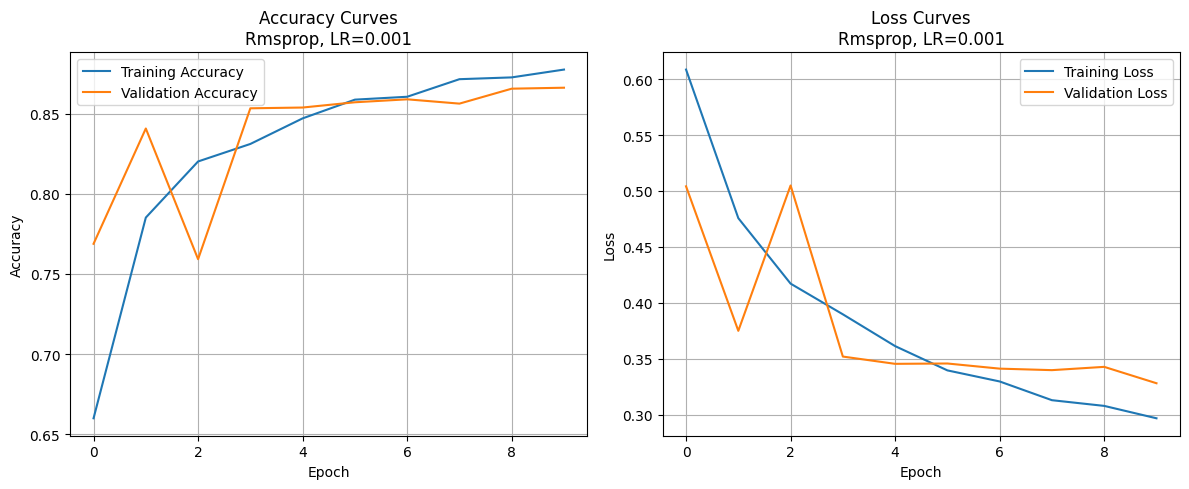

- Best optimizer: rmsprop with learning rate 0.001
- Best validation accuracy: 0.8662


In [ ]:
# Train with different optimizers and learning rates
results = []
optimizers = ['adam', 'rmsprop']
learning_rates = [0.001, 0.0001, 0.00001]

results_table = np.zeros((len(optimizers), len(learning_rates), 2))  # 2: train_acc, val_acc

for i, optimizer in enumerate(optimizers):
    for j, lr in enumerate(learning_rates):
        result = create_and_train_model(optimizer, lr)
        results.append(result)
        results_table[i, j, 0] = result['train_acc']
        results_table[i, j, 1] = result['val_acc']

# Find best validation accuracy
best_val_acc = 0
best_result = None

for result in results:
    if result['val_acc'] > best_val_acc:
        best_val_acc = result['val_acc']
        best_result = result

print("\nBest Model:")
print(f"Optimizer: {best_result['optimizer']}, Learning Rate: {best_result['learning_rate']}")
print(f"Training accuracy: {best_result['train_acc']:.4f}")
print(f"Validation accuracy: {best_result['val_acc']:.4f}")

# Create a 2x3 table of results
print("\nResults Table (Training Accuracy / Validation Accuracy):")
print("Optimizer | LR=0.001 | LR=0.0001 | LR=0.00001")
print("-" * 50)
for i, optimizer in enumerate(optimizers):
    row = f"{optimizer.ljust(9)} |"
    for j in range(len(learning_rates)):
        row += f" {results_table[i, j, 0]:.4f}/{results_table[i, j, 1]:.4f} |"
    print(row)

# Plot learning curves for the best model
plt.figure(figsize=(12, 5))

# Plot accuracy curves
plt.subplot(1, 2, 1)
plt.plot(best_result['history']['accuracy'], label='Training Accuracy')
plt.plot(best_result['history']['val_accuracy'], label='Validation Accuracy')
plt.title(f'Accuracy Curves\n{best_result["optimizer"].capitalize()}, LR={best_result["learning_rate"]}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss curves
plt.subplot(1, 2, 2)
plt.plot(best_result['history']['loss'], label='Training Loss')
plt.plot(best_result['history']['val_loss'], label='Validation Loss')
plt.title(f'Loss Curves\n{best_result["optimizer"].capitalize()}, LR={best_result["learning_rate"]}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('imdb_lstm_learning_curves.png')
plt.show()

print(f"- Best optimizer: {best_result['optimizer']} with learning rate {best_result['learning_rate']}")
print(f"- Best validation accuracy: {best_result['val_acc']:.4f}")